In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import urllib.request

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import numpy as np
import matplotlib.pyplot as plt
from discretize import TreeMesh
from discretize.utils import mkvc

In [2]:

import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh


from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact

C:\Users\gabri\AppData\Local\Temp\ipykernel_29512\1831878544.py:11: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import (


In [3]:
import os
import urllib.request
import tarfile

# Enlace de Google Drive (modificado para descarga directa)
data_source = "https://drive.google.com/uc?export=download&id=11wVRisOgXtP1hQC3GpttQeCT9kCszcpH"

# Descargar el archivo y guardar el nombre local
downloaded_data = "Datos_de_inversion_VCM.tar.gz"
print(f"Downloading data from: {data_source}")
urllib.request.urlretrieve(data_source, downloaded_data)
print(f"File downloaded: {downloaded_data}")

# Descomprimir el archivo .tar.gz
if tarfile.is_tarfile(downloaded_data):
    with tarfile.open(downloaded_data, "r:gz") as tar:
        # Extraer los archivos al directorio actual
        tar.extractall()
    print("Files extracted.")
else:
    print("The downloaded file is not a tar.gz file.")

# Definir el directorio que contiene los datos descomprimidos
dir_path = os.path.join("Datos_de_inversion_VCM", "")  # Ruta a la carpeta descomprimida

# Nombres de los archivos con rutas completas
topo_filename = os.path.join(dir_path, "Topografia_30k_puntos_SGC.txt")
data_filename = os.path.join(dir_path, "Estaciones_AGCM_SGC_Gravimetria.txt")

# Verificación de los archivos
if os.path.exists(topo_filename):
    print(f"Topo file located: {topo_filename}")
else:
    print(f"Topo file not found: {topo_filename}")

if os.path.exists(data_filename):
    print(f"Data file located: {data_filename}")
else:
    print(f"Data file not found: {data_filename}")

File downloaded: Datos_de_inversion_VCM.tar.gz
Files extracted.
Topo file located: Datos_de_inversion_VCM\Topografia_30k_puntos_SGC.txt
Data file located: Datos_de_inversion_VCM\Estaciones_AGCM_SGC_Gravimetria.txt


In [4]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))
xyz_topo

array([[4.73020641e+06, 2.04878027e+06, 1.88800000e+03],
       [4.73027160e+06, 2.04878018e+06, 1.85500000e+03],
       [4.73033680e+06, 2.04878008e+06, 1.83900000e+03],
       ...,
       [4.74176033e+06, 2.05882708e+06, 2.77400000e+03],
       [4.74182553e+06, 2.05882698e+06, 2.73700000e+03],
       [4.74189072e+06, 2.05882689e+06, 2.69100000e+03]], shape=(32400, 3))

In [5]:
# Load field data
dobs = np.loadtxt(str(data_filename))
dobs

array([[ 4.73288346e+06,  2.04934517e+06,  1.80256900e+03,
        -8.90000000e-01],
       [ 4.74026071e+06,  2.05106957e+06,  2.01436600e+03,
         1.37700000e+01],
       [ 4.73320546e+06,  2.05740545e+06,  2.12708800e+03,
        -5.59000000e+00],
       [ 4.73309152e+06,  2.05649289e+06,  1.95445000e+03,
        -3.48000000e+00],
       [ 4.73300153e+06,  2.05696556e+06,  1.98140800e+03,
        -4.60000000e+00],
       [ 4.73290347e+06,  2.05744521e+06,  1.99029900e+03,
        -4.91000000e+00],
       [ 4.73288487e+06,  2.05795418e+06,  2.02352400e+03,
        -5.13000000e+00],
       [ 4.73301557e+06,  2.05631196e+06,  1.95298300e+03,
        -2.28000000e+00],
       [ 4.73283490e+06,  2.05668786e+06,  1.96450000e+03,
        -3.07000000e+00],
       [ 4.73272286e+06,  2.05714852e+06,  1.99675200e+03,
        -3.78000000e+00],
       [ 4.73272530e+06,  2.05765649e+06,  2.00780400e+03,
        -4.56000000e+00],
       [ 4.73261652e+06,  2.05633914e+06,  2.19424100e+03,
      

In [6]:
topografia = xyz_topo[:, 0:3]
# Definir las ubicaciones de los receptores y los datos observados
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

In [7]:
topografia

array([[4.73020641e+06, 2.04878027e+06, 1.88800000e+03],
       [4.73027160e+06, 2.04878018e+06, 1.85500000e+03],
       [4.73033680e+06, 2.04878008e+06, 1.83900000e+03],
       ...,
       [4.74176033e+06, 2.05882708e+06, 2.77400000e+03],
       [4.74182553e+06, 2.05882698e+06, 2.73700000e+03],
       [4.74189072e+06, 2.05882689e+06, 2.69100000e+03]], shape=(32400, 3))

In [8]:
x = receiver_locations[:, 0]
y = receiver_locations[:, 1]
z = receiver_locations[:, 2]

x1 = topografia[:, 0]
y1 = topografia[:, 1]
z1 = topografia[:, 2]

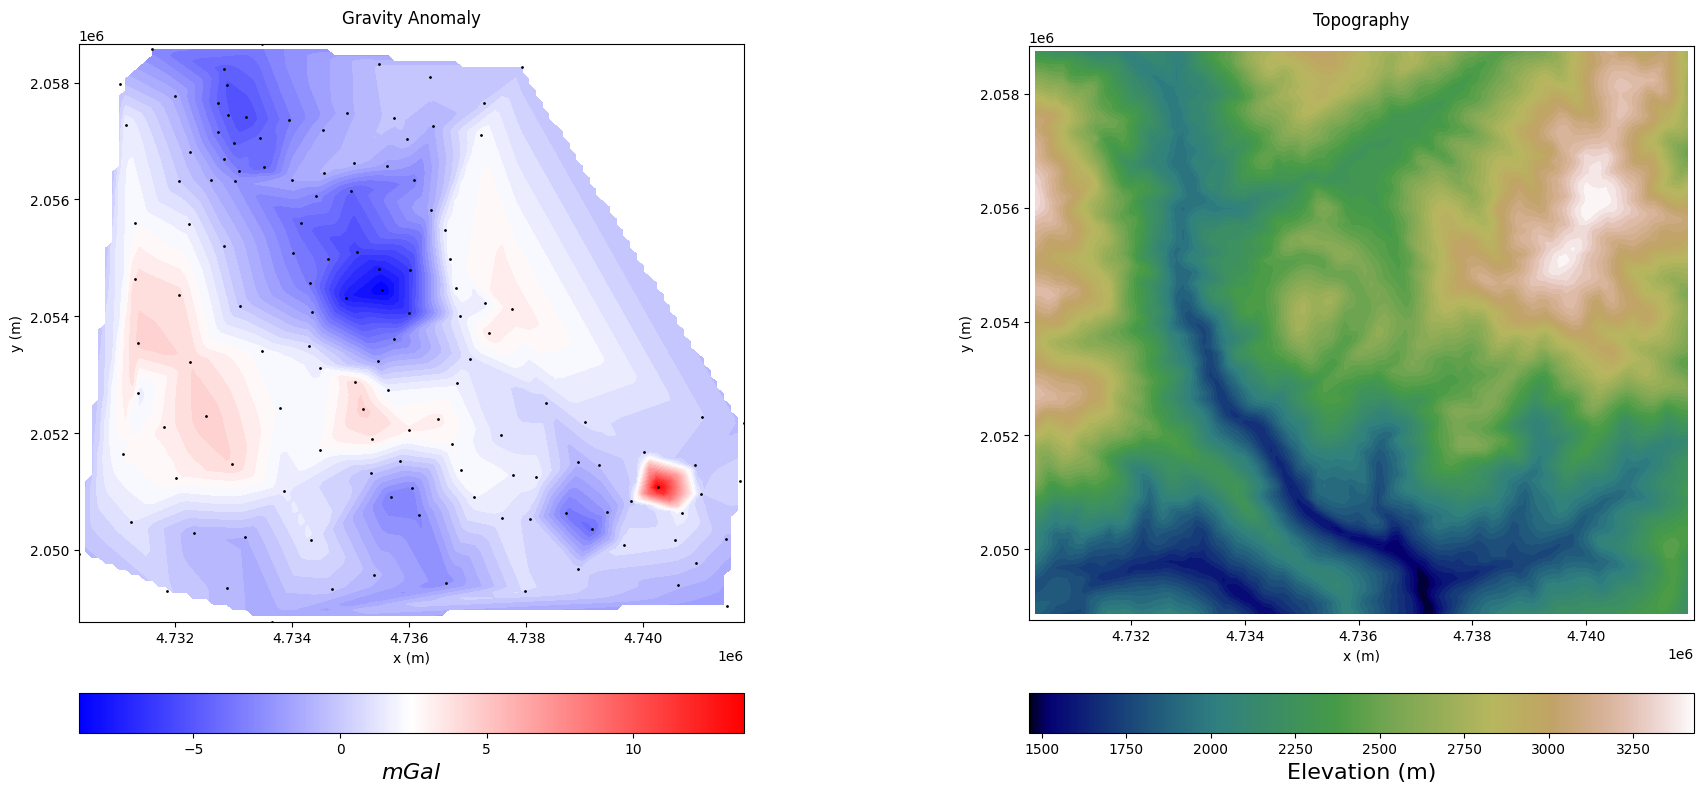

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# # Normalización de los datos de 'dobs' para el rango de -16 a 8
# norm = mpl.colors.Normalize(vmin=-9, vmax=-1)
# dobs_normalized = norm(dobs)  # Normalización de los datos
# dobs=dobs_normalized

# Crear la figura
fig = plt.figure(figsize=(19, 10))

# Primer gráfico: Anomalía de gravedad
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

# Usar el método plot2Ddata() para plotear los datos
# Asumiendo que plot2Ddata es una función definida previamente
# Asegúrate de que esta función reciba correctamente los datos normalizados.
plot2Ddata(
    receiver_locations,
    dobs,  # Usamos los datos normalizados
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)

ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

# Barra de color para la primera figura
cx1 = fig.add_axes([0.05, 0.25, 0.35, 0.04])
norm1 = mpl.colors.Normalize(vmin=np.min(dobs), vmax=np.max(dobs))
# Usar la normalización para la barra de colores
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

# Segundo gráfico: Topografía
ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    xyz_topo[:, 0:2],  # Coordenadas X, Y de la topografía
    xyz_topo[:, -1],    # Altura de la topografía (Z)
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)

ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Barra de color para la segunda figura
cx2 = fig.add_axes([0.55, 0.25, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(xyz_topo[:, -1]), vmax=np.max(xyz_topo[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("Elevation (m)", size=16)

# Mostrar el gráfico
plt.show()


In [10]:
#Definir desviación estandar de nuestros datos, en este caso, será de 1
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.05 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.6885


In [11]:
rel_unc = 0.02          # 2% relative (tune: 0.01–0.03)
floor_unc = 0.05        # mGal floor (tune from reductions / repeatability)
sigma = floor_unc + rel_unc * np.abs(dobs)
print(f"Unc stats -> floor={floor_unc:.3f} mGal, rel={100*rel_unc:.1f}%, "
      f"median σ={np.median(sigma):.3f} mGal")

Unc stats -> floor=0.050 mGal, rel=2.0%, median σ=0.083 mGal


In [12]:
# Definir los receptores (con los puntos XYZ). Los datos consisten en mediciones de anomalías verticales de gravedad.
# El conjunto de receptores debe definirse como una lista.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Definir el campo de la fuente
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define el survey (sondeo)
survey = gravity.survey.Survey(source_field)

In [13]:
#Definir los datos que serán invertidos
data_object = data.Data(survey, dobs=-dobs, standard_deviation=sigma)

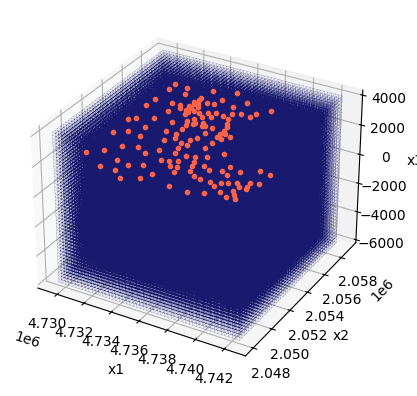

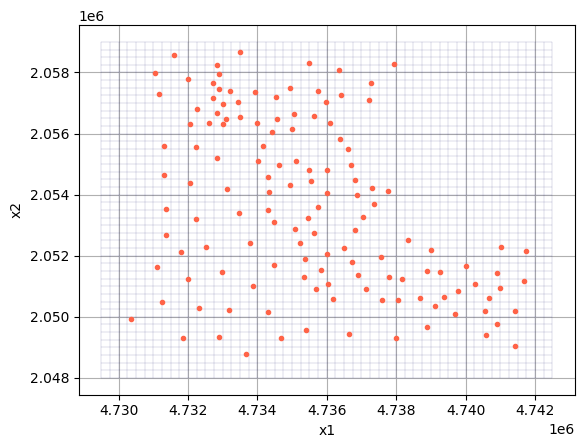

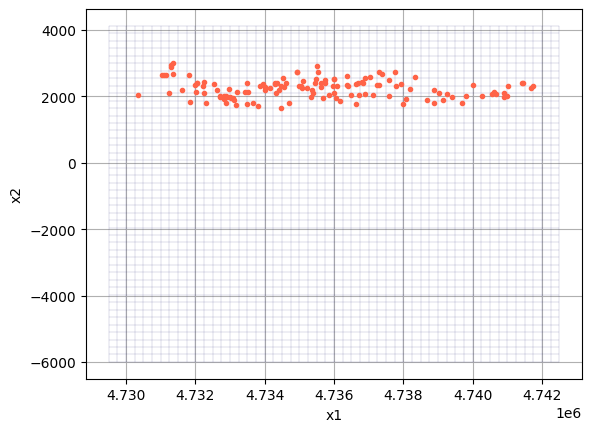

In [14]:
from discretize import TensorMesh
import matplotlib.pyplot as plt

dx = 250 
ncx = 52
dy = 250
ncy = 44
dz = 225
ncz = 45


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
mesh = TensorMesh([hx, hy, hz], x0=[4729500,2048000,-6000])
mesh.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, y, z, '.', color='tomato')

meshes = TensorMesh([hx, hy], x0=[4729500,2048000])
meshes.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, y, '.', color='tomato')

meshes1 = TensorMesh([hx, hz], x0=[4729500,-6000])
meshes1.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x, z, '.', color='tomato')

In [15]:
# Encuentra los índices de las celdas activas en el modelo de avance (las que están por debajo de la superficie)
active_tensor_cells = active_from_xyz(mesh, topografia)

# Definir la asignación del modelo a las celdas activas
n_tensor_active = int(active_tensor_cells.sum())

tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

In [16]:
starting_tensor_model = np.zeros(n_tensor_active)
active_cells_centers = mesh.cell_centers[active_tensor_cells]
z_active = active_cells_centers[:, 2]
z_normalized = (z_active - z_active.min()) / (z_active.max() - z_active.min())
starting_tensor_model = 0.3 - 0.6 * z_normalized

In [17]:
starting_tensor_model.shape

(85483,)

In [18]:
# Map for ignoring inactive cells when plotting
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [19]:
# Orden para ignorar celdas inactivas al trazar las celdas totales del modelo
tensor_plotting_map = maps.InjectActiveCells(mesh, active_tensor_cells, np.nan)

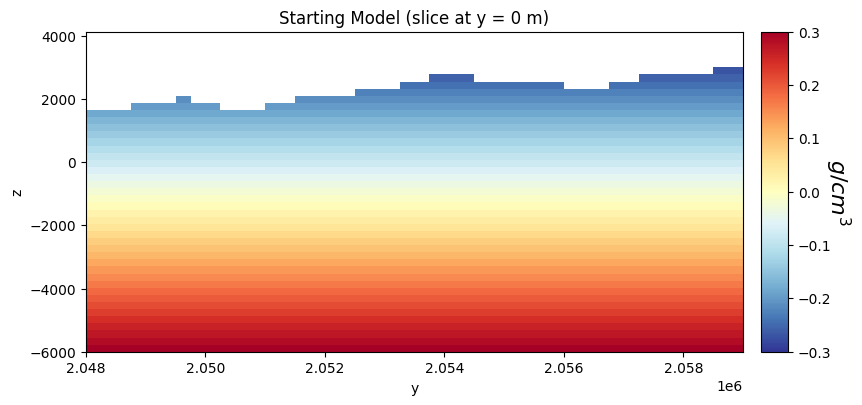

In [20]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(starting_tensor_model), vmax=np.max(starting_tensor_model))

mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="x",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [21]:
import vtk
models = {'Densidad':tensor_plotting_map*starting_tensor_model}
databse = mesh.to_vtk(models)
databse.save('modelo_de_iniciacion3_1.vtk')

In [22]:
#Definimos la física del problema de la gravedad utilizando la clase de simulación.
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="choclo",
    store_sensitivities="ram",
)

In [23]:
from simpeg import data_misfit
# Definir el desajuste de datos. Aquí el desajuste de datos es la norma L2 del residuo
# ponderado entre los datos observados y los datos predichos para un modelo dado.
# Dentro del desajuste de datos, el residuo entre los datos predichos y observados son
# normalizados por la desviación estándar de los datos.
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)


In [24]:
from simpeg.utils import depth_weighting

In [25]:
# #Aplicar depth weighting
# wr_Depth = utils.depth_weighting(
#     mesh, receiver_locations, active_cells=active_tensor_cells, exponent=3, threshold=5, v=2
#     )
# wr_Depth = wr_Depth**2

In [26]:
# Definir la regularización (función objetivo del modelo).
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_tensor_cells,
    mapping=tensor_model_map,
    alpha_s=1,    # Smallness - reduce para permitir más anomalía
    alpha_x=1.0,     # Smoothness X
    alpha_y=1.0,     # Smoothness Y  
    alpha_z=1,     # De menor magnitud para permitir capas horizontales
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
    # weights={'cell_weights':wr_Depth}
)     


In [ ]:
# Definir cómo se resuelve el problema de optimización. Aquí vamos a utilizar un enfoque
# Gauss-Newton proyectado que emplea el solucionador de gradiente conjugado.

opt_L2 = optimization.ProjectedGNCG(
    maxIter=20,
    maxIterLS=60,
    maxIterCG=70,
    tolCG=1e-3,
    lower=-0.4,   
    upper=0.5     
)

In [ ]:
# opt_L2 = optimization.InexactGaussNewton(
#     maxIter=100, maxIterLS=20, maxIterCG=10, tolCG=1e-2
# )

In [29]:
# Aquí definimos el problema inverso que hay que resolver
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [30]:
# Opciones para generar modelos recuperados y datos predichos para cada beta
save_iteration = directives.SaveOutputDictEveryIteration()
save_iteration.outDict = {}

# Añadir ponderaciones de sensibilidad
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=True,
                                                          threshold_value=1e-12,
                                                          threshold_method='amplitude',
                                                          normalization_method='maximum')

# Actualizar el precondicionador si depende del modelo
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True) #TRUE
# Definir un valor inicial para el parámetro de compensación (beta) entre el desajuste de los datos y la regularización.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10.0)
# Taza de diminución del valor de Beta
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)

target_misfit = directives.TargetMisfit(chifact=1)


# Las directivas se definen como una lista
directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_iteration,
]

In [ ]:
# Aquí combinamos el problema inverso y el conjunto de directivas
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Correr la inversión
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


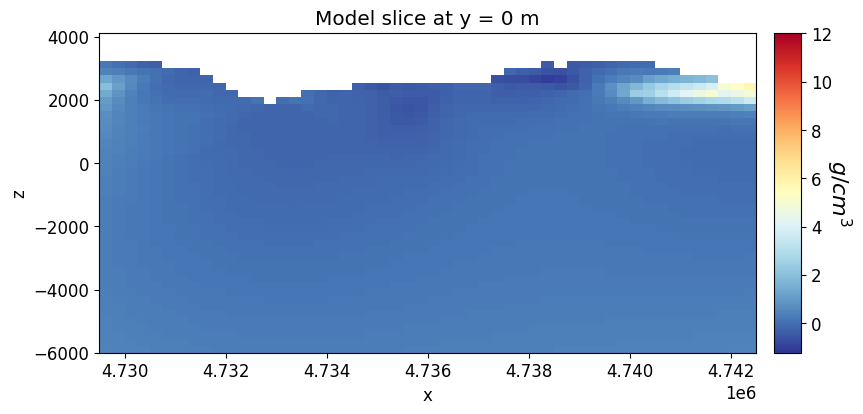

In [ ]:
# Ploter el modelo recuperado
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)


mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="y",
    ax=ax1,
    slice_loc=2054572,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()


In [ ]:
import vtk
models = {'Densidad':tensor_plotting_map*recovered_tensor_model}
databse = mesh.to_vtk(models)
databse.save('modelo_1_1.vtk')

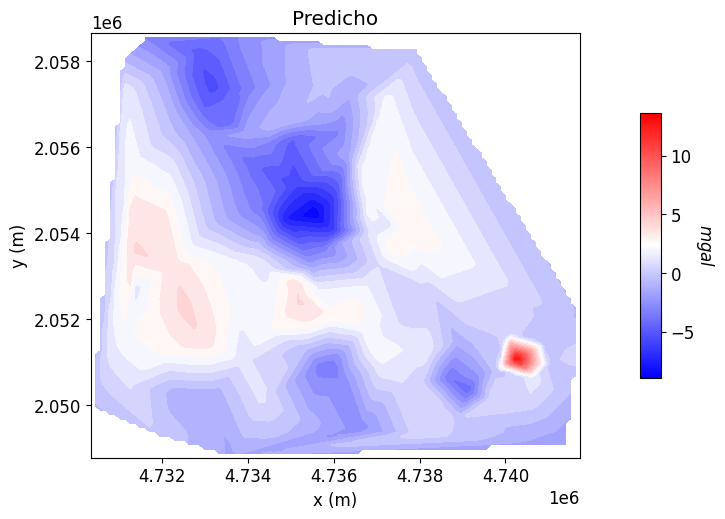

np.float32(13.661877)

In [ ]:
#Plotear el valor predicho
dpred = (-inv_prob_L2.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred), np.max(dpred)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=[np.min(dpred), np.max(dpred)],
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=np.min(dpred), vmax=np.max(dpred))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()
np.max(dpred)

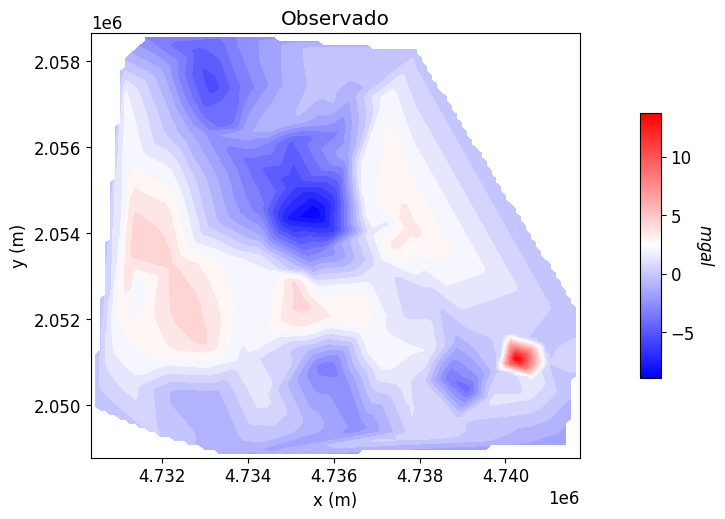

In [ ]:
#Plotear el valor observado
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

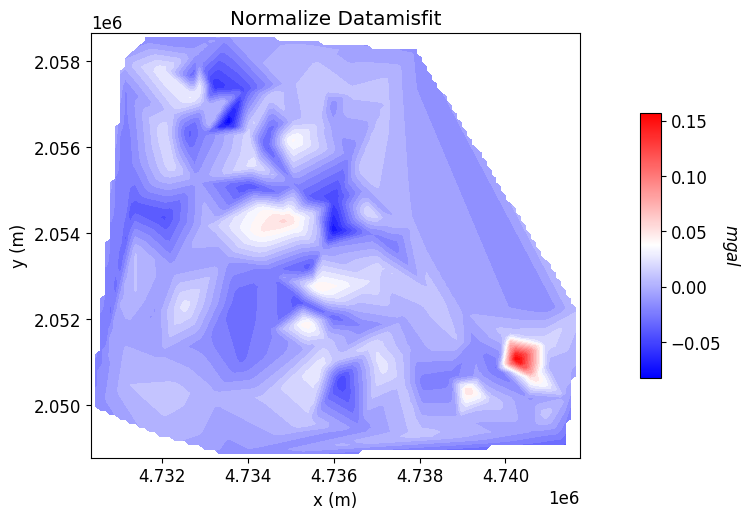

In [ ]:
data_misfit= (dobs - dpred) / uncertainties


mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit), vmax=np.max(data_misfit))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / sigma


In [ ]:
# Generate new data object
new_data_object = data.Data(survey, dobs=-dobs, standard_deviation=sigma)


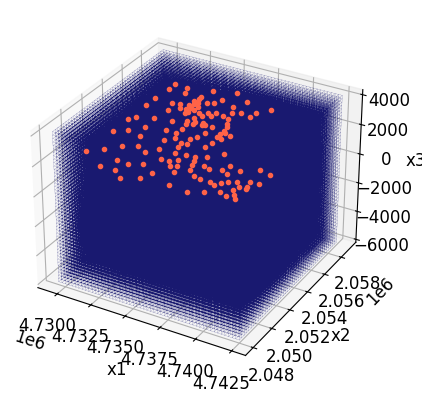

In [ ]:
dx = 250 
ncx = 52
dy = 250
ncy = 44
dz = 225
ncz = 45


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
tree_mesh = TensorMesh([hx, hy, hz], x0=[4729500,2048000,-6000])
tree_mesh.plot_grid(color="midnightblue", linewidth=0.1)

plt.plot(x, y, z, '.', color='tomato')

In [ ]:
active_tree_cells = active_from_xyz(tree_mesh, topografia)
n_tree_active = int(active_tree_cells.sum())

In [ ]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

In [ ]:
# starting_tree_model = 1e-6 * np.ones(n_tree_active)

In [ ]:
starting_tree_model = recovered_tensor_model.copy()

starting_tensor_model

ind_sphere = model_builder.get_indices_sphere(
    np.r_[4735320, 2054777, -1500], 1450, tree_mesh.gridCC
)
ind_sphere = ind_sphere[active_tree_cells]
starting_tree_model[ind_sphere] = -0.3

In [ ]:
tree_plotting_map = maps.InjectActiveCells(tree_mesh, active_tree_cells, np.nan)

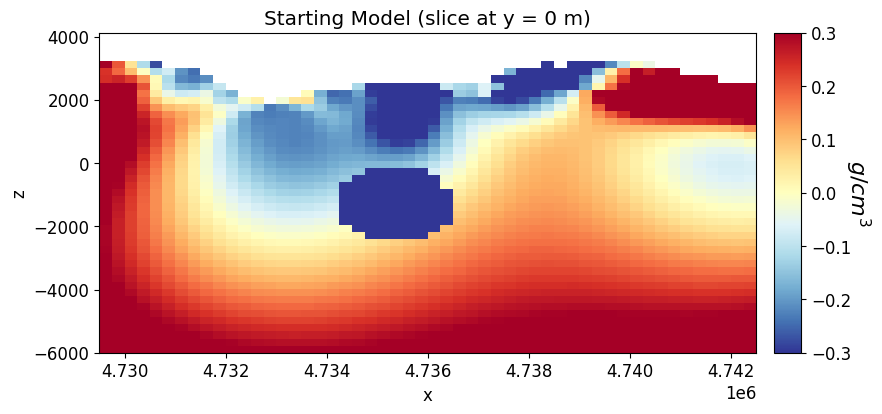

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(starting_tensor_model), vmax=np.max(starting_tensor_model))


norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.4)


mesh.plot_slice(
    tree_plotting_map * starting_tree_model,
    normal="y",
    ax=ax1,
    slice_loc=2054572,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_modelo_inicial"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'esfera_1700.svg'), dpi=500)

plt.show()

In [ ]:
k

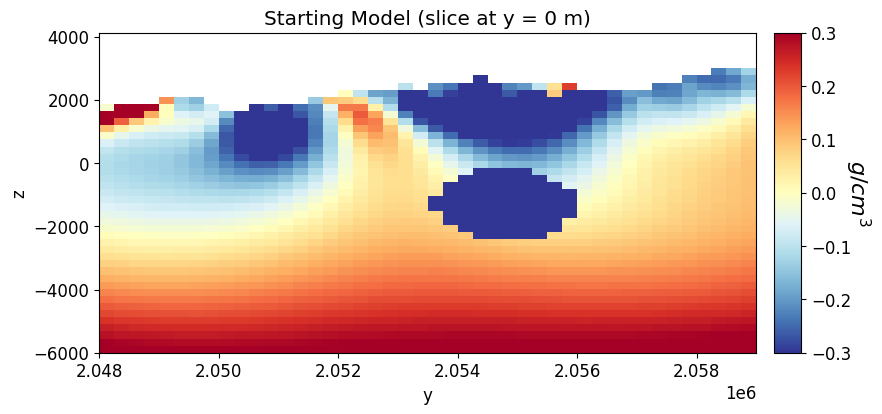

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])


norm = mpl.colors.Normalize(
    vmin=np.min(starting_tensor_model), vmax=np.max(starting_tensor_model))


norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)


mesh.plot_slice(
    tree_plotting_map * starting_tree_model,
    normal="x",
    ax=ax1,
    slice_loc=4735700,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# Ensure the folder exists
output_folder = "figuras_modelo_inicial"
os.makedirs(output_folder, exist_ok=True)

# Save the figure in the folder
plt.savefig(os.path.join(output_folder, 'esfera_1700_2.svg'), dpi=500)

plt.show()

In [ ]:
models = {'Densidad':tree_plotting_map*starting_tree_model}
databse = mesh.to_vtk(models)
databse.save('modelo_start_1_2.vtk')

In [ ]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tree_mesh,
    rhoMap=tree_model_map,
    ind_active=active_tree_cells,
    engine="choclo",
    store_sensitivities="ram",
    )

In [ ]:
from simpeg import data_misfit

dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)


In [ ]:
wr_Depth = utils.depth_weighting(
    mesh, receiver_locations, active_cells=active_tensor_cells, exponent=2, threshold=np.min(hx)/4, v=2
    )
wr_Depth = wr_Depth**2

In [ ]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=active_tree_cells,
    alpha_s=1e-5,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    reference_model=np.zeros(n_tree_active),
    reference_model_in_smooth=False,
    norms=[2,1,1,1],
    weights={'cell_weights':wr_Depth,
             }
)

In [ ]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=20, lower=-0.3, upper=0.4, maxIterLS=60, maxIterCG=50, tolCG=1e-4
)

In [ ]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [ ]:
from simpeg import directives

save_iteration_new = directives.SaveOutputDictEveryIteration()
save_iteration_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True,
                                                               threshold_value=1e-10,
                                                               threshold_method='amplitude',
                                                               normalization_method='maximum',)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=0.1)
beta_schedule_irls = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=2.0,
    coolingRate=2.0,
    chifact_start=1.0,
    f_min_change=1e-4,
    max_irls_iterations=30,
    beta_tol=1e-2,
)

tarjet_misfit= directives.TargetMisfit(chifact=1.0)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    beta_schedule_irls,
    update_jacobi_irls,
    tarjet_misfit,
    save_iteration_new
]



C:\Users\gabri\AppData\Local\Temp\ipykernel_27412\419426872.py:14: DeprecationWarning: Update_IRLS has been deprecated, please use InversionDirective. It will be removed in version 0.24.0 of SimPEG.
  update_irls = directives.Update_IRLS(


In [ ]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.72e+01  7.69e+03  2.72e+01  8.16e+03    9.83e+01      0              
   1  8.58e+00  7.58e+03  2.46e+01  7.80e+03    1.24e+02      0              
   2  2.14e+00  4.75e+03  2.29e+01  4.80e+03    1.21e+02      0              
   3  1.07e+00  3.63e+03  2.49e+01  3.65e+03    1.07e+02      0   Skip BFGS  
   4  2.68e-01  1.48e+03  2.65e+01  1.48e+03    1.09e+02      0              
   5  1.34e-01  1.32e+03  2.92e+01  1.32e+03    1.17e+02      2   Skip BFGS  
   6  3.35e-02  1.28e+03  3.29e+01  1.28e+03    1.16e+02      1              
   7  1.68e-02  1.19e+03  3.55e+01  1.19e+03    9.60e+01      2   Skip BFGS  
   8  4.19e-03  1.14e+03  3.86e+01  1.14e+03    1.04e+02      2              
   9  2.09e-03  8.29e+02

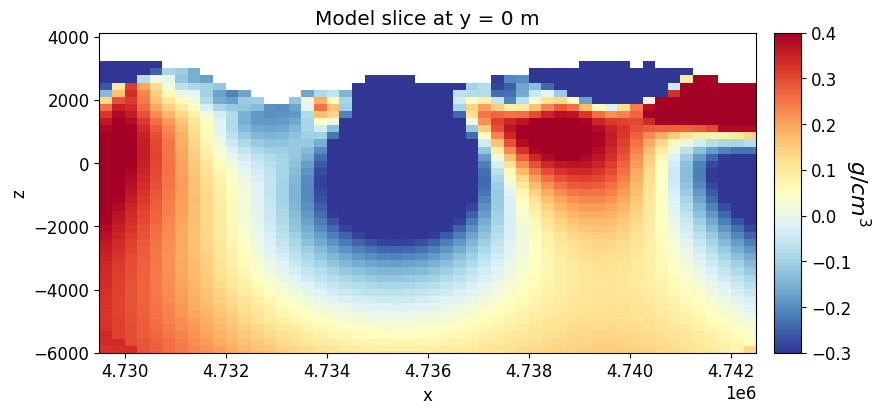

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.0)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="y",
    ax=ax1,
    slice_loc=2054372,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)


ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)



plt.show()

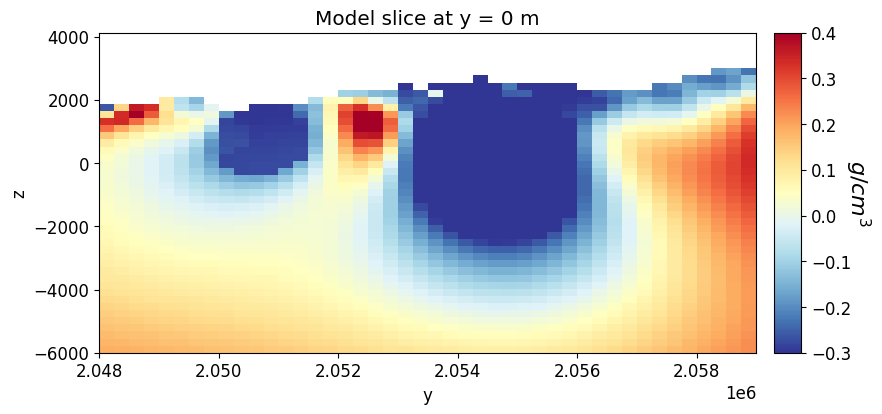

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )

# norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.0)

tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="x",
    ax=ax1,
    slice_loc=4735700,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)


ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

# # Ensure the folder exists
# output_folder = "figuras_2"
# os.makedirs(output_folder, exist_ok=True)

# # Save the figure in the folde
# plt.savefig(os.path.join(output_folder, 'x_inicial_maxIter=20_alpha=1e-5_beta=1e-4_LSshorten=None.svg'), dpi=500)

plt.show()

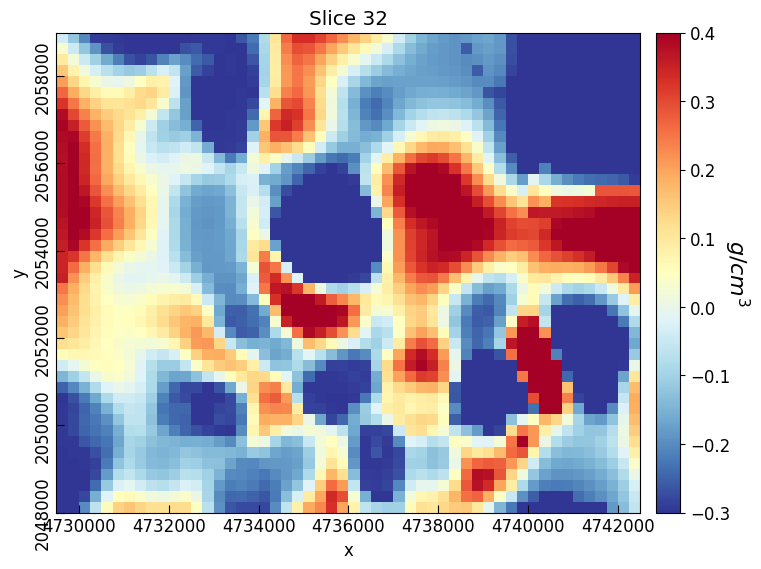

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=1260,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

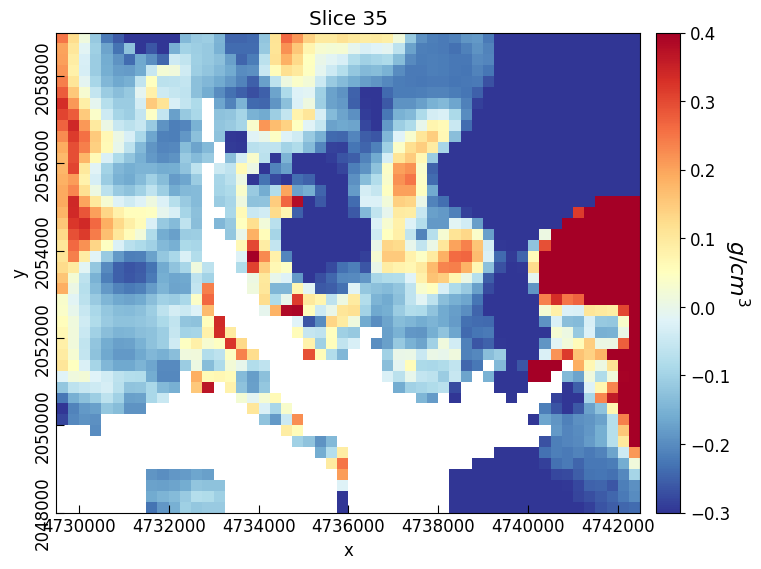

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tree_model), vmax=np.max(recovered_tree_model)
    )


tree_mesh.plot_slice(
    tree_plotting_map * recovered_tree_model,
    normal="z",
    dataloc=True,
    ax=ax1,
    slice_loc=1930,
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.tick_params(axis='both', direction='in', length=6)
ax1.ticklabel_format(style='plain', axis='both')
# Para más marcas
ax1.locator_params(axis='y', nbins=10)
ax1.locator_params(axis='x', nbins=8)
# Para rotar los números del eje Y
plt.setp(ax1.get_yticklabels(), rotation=90, verticalalignment='center')


ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

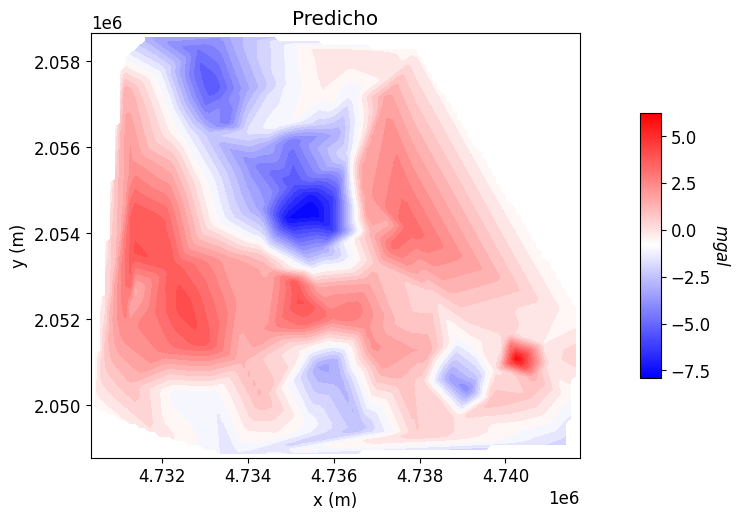

In [ ]:
dpred_new = (-inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new), np.max(dpred_new), np.min(-dpred_new), np.max(-dpred_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new,
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

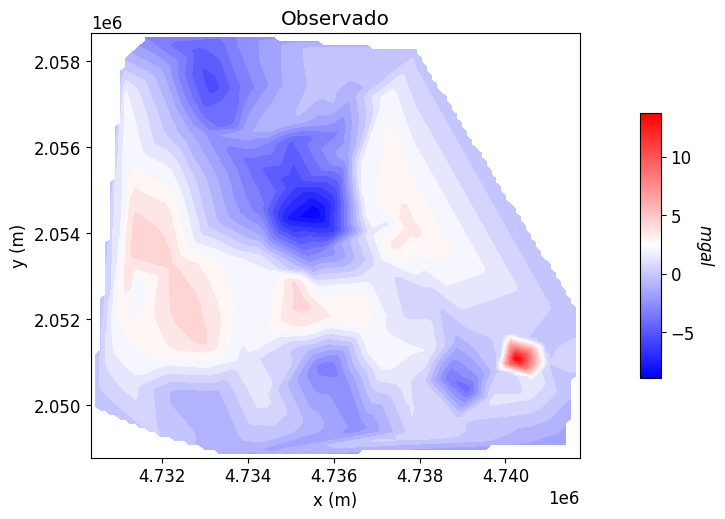

In [ ]:
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

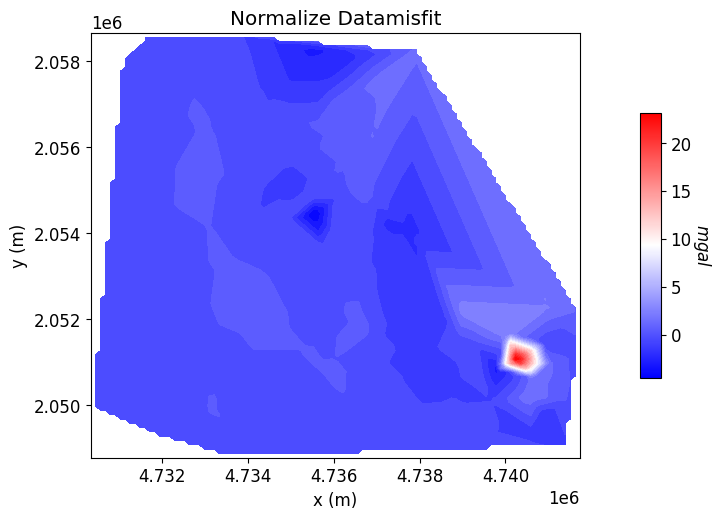

In [ ]:
data_misfit_new= (dobs - dpred_new) / sigma

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
models = {'Densidad':tree_plotting_map*recovered_tree_model}
databse = mesh.to_vtk(models)
databse.save('modelo_1_2.vtk')

In [ ]:
target_misfit.target

135.0